## Classify Tweets. Compare classifiers and select best model at run time. 

In [1]:
# Import File and Packages
import sklearn
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
%matplotlib inline
import re
import warnings
warnings.filterwarnings("ignore")

# Read csv file into data frame
tweet=pd.read_csv("Tweets.csv")

In [2]:
tweet.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


### Load and preprocess data using NLTK:
##### Tokenize, Clean, Stem, Lemmatize, Remove stopwords

In [3]:
# Preprocess the data {'negative': 0 , 'positive': 1 , 'neutral': 2}

df=tweet.iloc[:,[10,1]]
df.columns = ['data', 'target']
df['target']=df['target'].str.strip().str.lower()
df['target']=df['target'].map({'negative': 0 , 'positive': 1 , 'neutral': 2})

# Copy df to a temporary dataframe for pre-processing
# Below assignment is causing problems
dft=df
dft.head()

,data,target
0,@VirginAmerica What @dhepburn said.,2
1,@VirginAmerica plus you've added commercials t...,1
2,@VirginAmerica I didn't today... Must mean I n...,2
3,@VirginAmerica it's really aggressive to blast...,0
4,@VirginAmerica and it's a really big bad thing...,0


In [4]:
%%time
# Remove @tweets, numbers, hyperlinks that do not start with letters
dft['data']=dft['data'].str.replace("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|([0-9])"," ")

# tokenize into words
import nltk
dft['data']=dft['data'].apply(nltk.word_tokenize)

Wall time: 3.72 s


In [5]:
%%time
# stem the tokens
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer('english')
dft['data']=dft['data'].apply(lambda x: [stemmer.stem(y) for y in x])

Wall time: 2.85 s


In [6]:
%%time
# Lemmatizing
lemmatizer = nltk.WordNetLemmatizer()
dft['data']=dft['data'].apply(lambda x: [lemmatizer.lemmatize(y) for y in x])

Wall time: 2.77 s


In [7]:
from nltk.corpus import webtext
from nltk.collocations import BigramCollocationFinder
from nltk.metrics import BigramAssocMeasures


In [8]:
'''textWords = [w.lower() for w in dft['data']]

finder = BigramCollocationFinder.from_words(textWords)
finder.nbest(BigramAssocMeasures.likelihood_ration,10)
'''
#print(dft.data.apply.split(''))

"textWords = [w.lower() for w in dft['data']]\n\nfinder = BigramCollocationFinder.from_words(textWords)\nfinder.nbest(BigramAssocMeasures.likelihood_ration,10)\n"

In [9]:
%%time
# Remove stopwords
stopwords = nltk.corpus.stopwords.words('english')

# stem the stopwords
#create a list of stop words that you dont want to remove lik (not, no)
#create a loop that says take all the stop words except what is in the list 
stemmed_stops = [stemmer.stem(t) for t in stopwords]

# remove stopwords from stemmed/lemmatized tokens
dft['data']=dft['data'].apply(lambda x: [stemmer.stem(y) for y in x if y not in stemmed_stops])

# remove words whose length is <3
dft['data']=dft['data'].apply(lambda x: [e for e in x if len(e) >= 3])

Wall time: 2.33 s


In [10]:
%%time
# Detokenize cleaned dataframe for vectorizing
dft['data']=dft['data'].str.join(" ")

Wall time: 16 ms


In [11]:
dft.head(20)

,data,target
0,said,2
1,plus commerci experi tacki,1
2,today must mean need take anoth trip,2
3,realli aggress blast obnoxi entertain guest fa...,0
4,realli big bad thing,0
5,serious would pay flight seat play realli bad ...,0
6,yes near everi time fli ear worm away,1
7,realli miss prime opportun men without hat parodi,2
8,well,1
9,amaz arriv hour ear good,1


### Printing data shape:

In [12]:
#Print attributes of tweet, X and y
print('Shape of original file : ', tweet.shape)
print('All columns of the original file : ', tweet.columns.tolist() , '\n')
print('Columns dft dataframe : ',dft.columns.tolist(), '\n') 
print('Shape data and target : ', dft['data'].shape, dft['target'].shape, '\n')
print('Mood Count target :\n',tweet['airline_sentiment'].value_counts())

Shape of original file :  (14640, 15)
All columns of the original file :  ['tweet_id', 'airline_sentiment', 'airline_sentiment_confidence', 'negativereason', 'negativereason_confidence', 'airline', 'airline_sentiment_gold', 'name', 'negativereason_gold', 'retweet_count', 'text', 'tweet_coord', 'tweet_created', 'tweet_location', 'user_timezone'] 

Columns dft dataframe :  ['data', 'target'] 

Shape data and target :  (14640,) (14640,) 

Mood Count target :
 negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64


### Printing accuracy using DummyClassifier (baseline) w.r.t Train Test Split:
#### Performance Measure: Accuracy_score and runtime  
##### Testing the dataset using Dummy classifier and train test. Purpose is to find an optimum random state for train test which gives the best accuracy.

In [13]:
%%time
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer

X=dft['data']
y=dft['target']

arr_Accu=[]

#Using train_test_split
#Selecting the best random state and comapring the accuracy using Dummy Classifier
for i in range(1,20):
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.67, random_state=i)

    vect = CountVectorizer(stop_words='english',analyzer="word",min_df = 2, max_df = 0.8)
    X_train_dtm = vect.fit_transform(X_train)
    X_test_dtm = vect.transform(X_test)
    feat_dtm = vect.get_feature_names()
    #feat_dtm

    clf = DummyClassifier()
    clf.fit(X_train_dtm, y_train)
    y_pred = clf.predict(X_test_dtm)

    accuracy = metrics.accuracy_score(y_test, y_pred)
    #print(accuracy)
    arr_Accu.append(accuracy)

for j in range(1,20):
    print("Random State : ", j, "   Accuracy : ", arr_Accu[j-1])

Random State :  1    Accuracy :  0.45695364238410596
Random State :  2    Accuracy :  0.46378311258278143
Random State :  3    Accuracy :  0.47413079470198677
Random State :  4    Accuracy :  0.4639900662251656
Random State :  5    Accuracy :  0.4650248344370861
Random State :  6    Accuracy :  0.4641970198675497
Random State :  7    Accuracy :  0.46875
Random State :  8    Accuracy :  0.47392384105960267
Random State :  9    Accuracy :  0.46750827814569534
Random State :  10    Accuracy :  0.45695364238410596
Random State :  11    Accuracy :  0.46254139072847683
Random State :  12    Accuracy :  0.4735099337748344
Random State :  13    Accuracy :  0.4654387417218543
Random State :  14    Accuracy :  0.47123344370860926
Random State :  15    Accuracy :  0.4679221854304636
Random State :  16    Accuracy :  0.4646109271523179
Random State :  17    Accuracy :  0.4718543046357616
Random State :  18    Accuracy :  0.46295529801324503
Random State :  19    Accuracy :  0.4604718543046358
Wall

### Printing accuracy using Dummy Classifier w.r.t K-fold:
#### Performance Measure: Accuracy_score and runtime
##### Testing the dataset using dummy classifier and K-fold. Purpose is to find an optimum K value for CV which gives the best accuracy.

In [14]:
%%time
#Using K-fold validation
#Selecting the best fold and comparing the accuracy using Naive Bayes
from sklearn.model_selection import cross_val_score
arr_Accu=[]

#Selecting the best random state and comparing the accuracy using dummy classifier
for i in range(3,15):

    vect = CountVectorizer(stop_words='english',analyzer="word",min_df = 2, max_df = 0.8)
    X_dtm = vect.fit_transform(X)

    clf = DummyClassifier()
    accuracy = cross_val_score(clf, X_dtm, y, cv=i, scoring='accuracy')
    
    arr_Accu.append(np.mean(accuracy))

#print(arr_Accu)
for j in range(3,15):
    print("K-Fold : ", j, "   Accuracy : ", arr_Accu[j-3])

K-Fold :  3    Accuracy :  0.4614070746462751
K-Fold :  4    Accuracy :  0.4614063338998017
K-Fold :  5    Accuracy :  0.4716519738357934
K-Fold :  6    Accuracy :  0.4652312803802554
K-Fold :  7    Accuracy :  0.46188020176380434
K-Fold :  8    Accuracy :  0.46372654087323056
K-Fold :  9    Accuracy :  0.4633206227619417
K-Fold :  10    Accuracy :  0.46529978198076466
K-Fold :  11    Accuracy :  0.4717933233363304
K-Fold :  12    Accuracy :  0.4627056275146435
K-Fold :  13    Accuracy :  0.460722422036015
K-Fold :  14    Accuracy :  0.461686373964821
Wall time: 2.25 s


### Print top features with frequency:

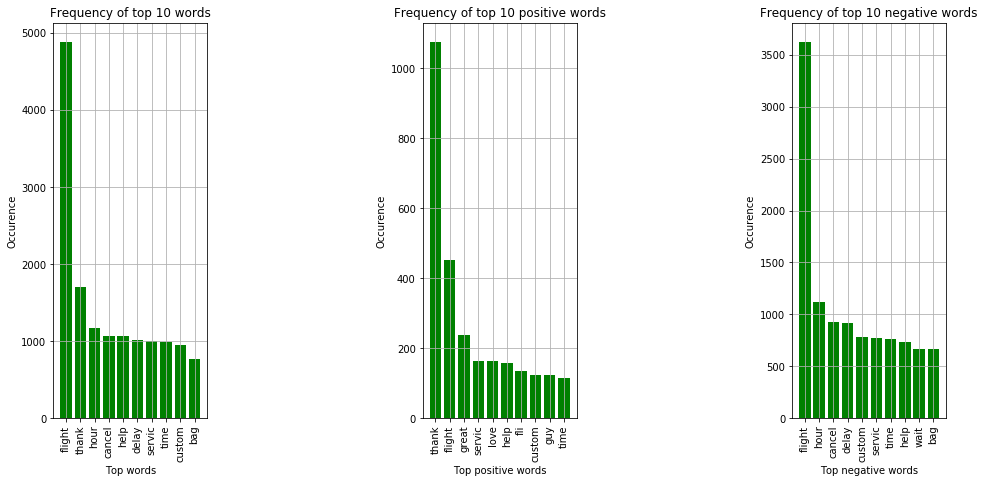

In [15]:

def print_top_words():    
    # Print top words
    vect = CountVectorizer(stop_words='english',analyzer="word",min_df = 2, max_df = 0.8)
    data_dtm = vect.fit_transform(dft['data'])
    feat_dtm = vect.get_feature_names()

    # Count words
    freq_tbl=pd.DataFrame({'Word':feat_dtm,'Occurence':np.asarray(data_dtm.sum(axis=0)).ravel().tolist()})
    freq_tbl['Word']=freq_tbl['Word'].str.strip()

    # Print top words
    topt = freq_tbl.sort_values(['Occurence'], ascending=[False]).head(10)
    y = topt['Occurence']
    plt.grid()
    X = range(1, 11)
    plt.bar(X,y,color='g')
    plt.xlabel('Top words')
    plt.ylabel('Occurence')
    plt.title('Frequency of top 10 words')
    plt.xticks(X,topt['Word'],rotation=90)
    
def print_top_neg_words():    
    # Print top negative words
    vect = CountVectorizer(stop_words='english',analyzer="word",min_df = 2, max_df = 0.8)
    filt = dft[dft['target'] == 0]
    data_dtm = vect.fit_transform(filt['data'])
    feat_dtm = vect.get_feature_names()

    # Count words
    freq_tbl=pd.DataFrame({'Word':feat_dtm,'Occurence':np.asarray(data_dtm.sum(axis=0)).ravel().tolist()})
    freq_tbl['Word']=freq_tbl['Word'].str.strip()

    # Print top negative words
    topt = freq_tbl.sort_values(['Occurence'], ascending=[False]).head(10)
    y = topt['Occurence']
    plt.grid()
    X = range(1, 11)
    plt.bar(X,y,color='g')
    plt.xlabel('Top negative words')
    plt.ylabel('Occurence')
    plt.title('Frequency of top 10 negative words')
    plt.xticks(X,topt['Word'],rotation=90)
    
def print_top_pos_words():    
    # Print top positive words
    vect = CountVectorizer(stop_words='english',analyzer="word",min_df = 2, max_df = 0.8)
    filt = dft[dft['target'] == 1]
    data_dtm = vect.fit_transform(filt['data'])
    feat_dtm = vect.get_feature_names()

    # Count words
    freq_tbl=pd.DataFrame({'Word':feat_dtm,'Occurence':np.asarray(data_dtm.sum(axis=0)).ravel().tolist()})
    freq_tbl['Word']=freq_tbl['Word'].str.strip()

    # Print top positive words
    topt = freq_tbl.sort_values(['Occurence'], ascending=[False]).head(10)
    y = topt['Occurence']
    plt.grid()
    X = range(1, 11)
    plt.bar(X,y,color='g')
    plt.xlabel('Top positive words')
    plt.ylabel('Occurence')
    plt.title('Frequency of top 10 positive words')
    plt.xticks(X,topt['Word'],rotation=90)


plt.figure(1,figsize=(16, 16))
plt.subplot(251)
print_top_words()  
plt.subplot(253)
print_top_pos_words()
plt.subplot(255)
print_top_neg_words()


### Comparing different model accuracy using Train Test:
#### 1. Multinomial Naive Bayes
#### 2. Logistic Regression
#### 3. KNN
#### 4. Decision Tree
#### 5. Random Forest
#### 6. ADA Boost Classifier
#### 7. LinearSVC
#### 8. Gaussian Naive Bayes
### Performance Measure: Accuracy_score and Run time
##### Each model mentioned above will be tested for accuracy and Run time using Train Test and the best performing model will be automatically selected.

In [16]:
%%time
import time
#Train Test split data with random state=11
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.67, random_state=11)

#Vectorize
vect = CountVectorizer(stop_words='english',analyzer="word",min_df = 2, max_df = 0.8)
X_train_dtm = vect.fit_transform(X_train)
X_test_dtm = vect.transform(X_test)
feat_dtm = vect.get_feature_names()

#Initialize classifier stats
clf_stats=pd.DataFrame()

Wall time: 178 ms


In [17]:
# Multinomial Naive Bayes
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB()

start_time=time.time()
clf.fit(X_train_dtm, y_train)
runtime = time.time()-start_time
y_pred = clf.predict(X_test_dtm)
accuracy = metrics.accuracy_score(y_test, y_pred)

print('Accuracy : ',accuracy)

#Store stats for classifier
clf_stats=clf_stats.append({'Classifier': 'Multinomial Naive Bayes', 'Accuracy': accuracy, 'Runtime': runtime, 'Callable': 'clf = MultinomialNB()'}, ignore_index=True)

Accuracy :  0.7622102649006622


In [18]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression()

start_time=time.time()
clf.fit(X_train_dtm, y_train)
runtime = time.time()-start_time
y_pred = clf.predict(X_test_dtm)
accuracy = metrics.accuracy_score(y_test, y_pred)
print('Accuracy : ',accuracy)

#Store stats for classifier
clf_stats=clf_stats.append({'Classifier': 'Logistic Regression', 'Accuracy': accuracy, 'Runtime': runtime, 'Callable': 'clf = LogisticRegression()'}, ignore_index=True)

Accuracy :  0.7702814569536424


In [19]:
# K Nearest Neighbour
from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier(n_neighbors=2)

start_time=time.time()
clf.fit(X_train_dtm, y_train)
runtime = time.time()-start_time
y_pred = clf.predict(X_test_dtm)
accuracy = metrics.accuracy_score(y_test, y_pred)

print('Accuracy : ',accuracy)

#Store stats for classifier
clf_stats=clf_stats.append({'Classifier': 'KNN', 'Accuracy': accuracy, 'Runtime': runtime, 'Callable': 'clf = KNeighborsClassifier(n_neighbors=2)'}, ignore_index=True)

Accuracy :  0.6047185430463576


In [20]:
# Decision Tree
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(criterion='entropy')

start_time=time.time()
clf.fit(X_train_dtm, y_train)
runtime = time.time()-start_time
y_pred = clf.predict(X_test_dtm)
accuracy = metrics.accuracy_score(y_test, y_pred)

print('Accuracy : ',accuracy)

#Store stats for classifier
clf_stats=clf_stats.append({'Classifier': 'Decision Trees', 'Accuracy': accuracy, 'Runtime': runtime, 'Callable': 'clf = DecisionTreeClassifier(criterion=''entropy'')'}, ignore_index=True)

Accuracy :  0.683567880794702


In [21]:
# RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(criterion='entropy')

start_time=time.time()
clf.fit(X_train_dtm, y_train)
runtime = time.time()-start_time
y_pred = clf.predict(X_test_dtm)
accuracy = metrics.accuracy_score(y_test, y_pred)

print('Accuracy : ',accuracy)

#Store stats for classifier
clf_stats=clf_stats.append({'Classifier': 'Random Forest', 'Accuracy': accuracy, 'Runtime': runtime, 'Callable': 'clf = RandomForestClassifier(criterion=''entropy'')'}, ignore_index=True)

Accuracy :  0.734271523178808


In [22]:
# AdaBoostClassifier
from sklearn.ensemble import AdaBoostClassifier
clf = AdaBoostClassifier()

start_time=time.time()
clf.fit(X_train_dtm, y_train)
runtime = time.time()-start_time
y_pred = clf.predict(X_test_dtm)
accuracy = metrics.accuracy_score(y_test, y_pred)

print('Accuracy : ',accuracy)

#Store stats for classifier
clf_stats=clf_stats.append({'Classifier': 'ADA Boost', 'Accuracy': accuracy, 'Runtime': runtime, 'Callable': 'clf = AdaBoostClassifier()'}, ignore_index=True)

Accuracy :  0.6930877483443708


In [23]:
# SVM SVC
from sklearn.svm import LinearSVC
clf = LinearSVC()

start_time=time.time()
clf.fit(X_train_dtm, y_train)
runtime = time.time()-start_time
y_pred = clf.predict(X_test_dtm)
accuracy = metrics.accuracy_score(y_test, y_pred)

print('Accuracy : ',accuracy)

#Store stats for classifier
clf_stats=clf_stats.append({'Classifier': 'SVM SVC', 'Accuracy': accuracy, 'Runtime': runtime, 'Callable': 'clf = LinearSVC()'}, ignore_index=True)

Accuracy :  0.7479304635761589


In [24]:
# GaussianNB
# Not good with words
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()

start_time=time.time()
clf.fit(X_train_dtm.toarray(), y_train)
runtime = time.time()-start_time
y_pred = clf.predict(X_test_dtm.toarray())
accuracy = metrics.accuracy_score(y_test, y_pred)

print('Accuracy : ',accuracy)

#Store stats for classifier
clf_stats=clf_stats.append({'Classifier': 'Gaussian NB', 'Accuracy': accuracy, 'Runtime': runtime, 'Callable': 'clf = GaussianNB()'}, ignore_index=True)

Accuracy :  0.3785182119205298


### Plotting Classifier vs Accuracy and Runtime:

                Classifier  Accuracy   Runtime
1      Logistic Regression  0.770281  0.118931
0  Multinomial Naive Bayes  0.762210  0.002999
6                  SVM SVC  0.747930  0.420773
4            Random Forest  0.734272  0.650606
5                ADA Boost  0.693088  0.325831
3           Decision Trees  0.683568  0.778568
2                      KNN  0.604719  0.001998
7              Gaussian NB  0.378518  0.785548


([<matplotlib.axis.XTick at 0x201e1206b48>,
 <a list of 8 Text xticklabel objects>)

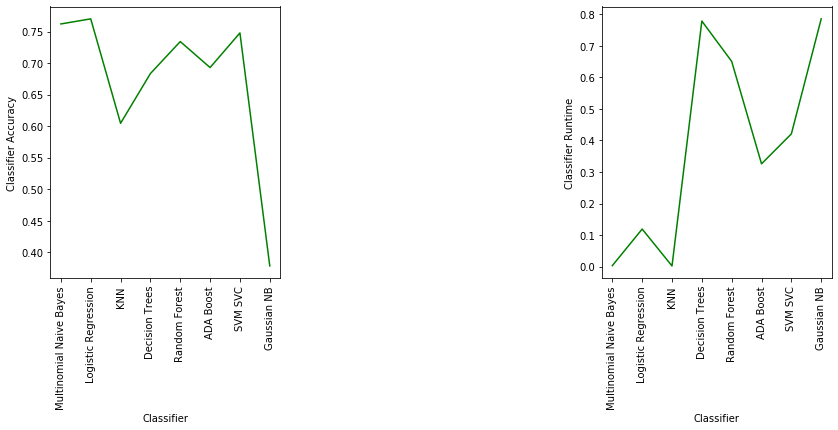

In [25]:
import matplotlib.pyplot as plt
%matplotlib inline

print (clf_stats[['Classifier','Accuracy','Runtime']].sort_values(['Accuracy'], ascending=[False]))
#Plot performance measures of classifiers

x=range(1,(len(clf_stats.Classifier)+1))
plt.figure(1,figsize=(14, 5))

plt.subplot(131)
plt.xlabel('Classifier')
plt.ylabel('Classifier Accuracy')
plt.plot(x, clf_stats['Accuracy'],color='g')
plt.xticks(x,clf_stats.Classifier,rotation=90)

plt.subplot(133)
plt.xlabel('Classifier')
plt.ylabel('Classifier Runtime')
plt.plot(x, clf_stats['Runtime'],color='g')
plt.xticks(x,clf_stats.Classifier,rotation=90)    

### Classifying new tweets: Fit model, Clean Tweet, Predict Mood
#### Clean incoming new tweet:

In [26]:
# Clean input tweet

def fmt_input_tweet(txt):
    
    # Remove @tweets, numbers, hyperlinks that do not start with letters
    txt = re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|([0-9])"," ",txt)
    #print(txt)
    
    # tokenize into words
    tokens = [word for word in nltk.word_tokenize(txt)]
    #print(tokens)

    # only keep tokens that start with a letter (using regular expressions)
    clean_tokens = [token for token in tokens if re.search(r'^[a-zA-Z]+', token)]
    #print('clean_tokens:\n',clean_tokens)

    # stem the tokens
    stemmer = SnowballStemmer('english')
    stemmed_tokens = [stemmer.stem(t) for t in clean_tokens]
    #print('stemmed_tokens:\n',stemmed_tokens)

    #Lemmatizing
    lemmatizer = nltk.WordNetLemmatizer()
    lem_tokens = [lemmatizer.lemmatize(t) for t in stemmed_tokens]
    #print('lemmatizer : \n',lem_tokens)
    
    #Remove stopwords
    stopwords = nltk.corpus.stopwords.words('english')

    # stem the stopwords
    stemmed_stops = [stemmer.stem(t) for t in stopwords]

    # remove stopwords from stemmed/lemmatized tokens
    lem_tokens_no_stop = [stemmer.stem(t) for t in lem_tokens if t not in stemmed_stops]

    # remove words whose length is <3
    clean_lem_tok = [e for e in lem_tokens_no_stop if len(e) >= 3]
    #print('clean_lem_tok: ',clean_lem_tok)
    
    # Detokenize new tweet for vector processing
    new_formatted_tweet=" ".join(clean_lem_tok)
    #print('new_formatted_tweet: ',new_formatted_tweet)
    
    return new_formatted_tweet
    

### Classify incoming new tweet:

In [27]:
import pickle 

In [28]:
# Logistic Regression performs better. So it will automatically used as an appropriate classifier

# Vectorize, fit, transform. Select model randomly
vect = CountVectorizer(stop_words='english', analyzer="word", min_df = 2, max_df = 0.8)
X_dtm = vect.fit_transform(X)
feat_dtm = vect.get_feature_names()

# Select the best performing classifier
Call_clf = str(clf_stats[['Callable','Accuracy']].sort_values(['Accuracy'], ascending=[False]).head(1).iloc[:,(0)])
temp = Call_clf.__repr__()
Call_clf = temp[temp.index('c'):(temp.index(')'))+1]
print('Model :',temp[(temp.index('=') + 1) : temp.index('(')])
exec(Call_clf)
clf.fit(X_dtm.toarray(), y) 


# Save the model
pickle.dump(clf, open('Tweet_Classifier.plk', 'wb'))
pickle.dump(vect, open("vectorizer.plk", "wb")) 

def classify_new_tweet(new_twt):  

    fmt_twt = fmt_input_tweet(new_twt)
    fmt_twt_dtm = vect.transform([fmt_twt])[0]
    #print('Formatted Tweet :',fmt_twt)
    pred = clf.predict(fmt_twt_dtm.toarray())

    def mood(x):
        return {
            0: 'negative',
            1: 'positive',
            2: 'neutral'
        }[x]

    print('Mood of the incoming tweet is:',mood(pred[0]))

Model :  LogisticRegression


In [29]:
twt='@united Thanks I had a great flight. '
classify_new_tweet(twt)

Mood of the incoming tweet is: positive


In [30]:
# Predict performance of random prediction. Testing for positive classes.
y_random_pred = np.ones(y.shape[0])
accuracy = metrics.accuracy_score(y, y_random_pred)
print('Accuracy of random (positive) prediction : ',accuracy)

Accuracy of random (positive) prediction :  0.16140710382513662


In [31]:
# Predict performance of majority class prediction. Testing for negative classes.
y_random_pred = np.zeros(y.shape[0])
accuracy = metrics.accuracy_score(y, y_random_pred)
print('Accuracy of majority class (negative) prediction : ',accuracy)

Accuracy of majority class (negative) prediction :  0.6269125683060109
